# Prepare text files for each entry
- reference
- Pero OCR
- Tesseract OCR

In [2]:
import os.path

In [3]:
DATASET_PATH = os.path.abspath("../../dataset/supervised")
DATASET_PATH

'/home/carlinet/repos/paper-ner-bench-das22/dataset/supervised'

In [4]:
ref_path = os.path.join(DATASET_PATH, "10-ref-ocr-ner-json", "all.json")
pero_path = os.path.join(DATASET_PATH, "21-ocr-pero-final", "all.json")
tess_path = os.path.join(DATASET_PATH, "22-ocr-tess-final", "all.json")

## Text file generation

In [5]:
import json
import io

In [6]:
def generate_text_files(json_path, output_dir):
    entries = None
    with open(json_path) as in_file:
        entries = json.load(in_file)
    for entry in entries:
        out_filename = f'{entry["book"]}-{entry["page"]:04d}-{entry["id"]:04d}.txt'
        out_path = os.path.join(output_dir, out_filename)
        text = entry["text_ocr"]
        with io.open(out_path, "wt", encoding="UTF-8", newline='', errors="strict") as file_output:
            file_output.write(text)


In [7]:
for (in_, out) in [(ref_path, "ref"), (pero_path, "pero"), (tess_path, "tess")]:
    out_dir = os.path.join(DATASET_PATH, "80-ocr-text-files", out)
    print(out)
    generate_text_files(in_, out_dir)

ref


FileNotFoundError: [Errno 2] No such file or directory: '/home/carlinet/repos/paper-ner-bench-das22/dataset/supervised/80-ocr-text-files/ref/Bottin1_1820-0107-0286.txt'

## Generate report OCR report

In [116]:
import OCRMetrics
import pandas as pd
import json

with open(ref_path) as f:
    reference = json.load(f)
with open(pero_path) as f:
    pero = json.load(f)
with open(tess_path) as f:
    tess = json.load(f)

uid = lambda x: (x["book"], x["page"], x["id"]) 
ref = { uid(x) : x["text_ocr"] for x in reference }
boxes = { uid(x) : tuple(int(r) for r in x["box"]) for x in reference }
pero = { uid(x) : x["text_ocr"] for x in pero }
tess = { uid(x) : x["text_ocr"] for x in tess }
all_keys = set(ref.keys()) | set(pero.keys()) | set(tess.keys())

pero_scores = { k : OCRMetrics.align(ref[k], pero[k]) for k in all_keys }
tess_scores = { k : OCRMetrics.align(ref[k], tess[k]) for k in all_keys }

def make_df(scores, index):
    stats = { k : r.stats for k,r in scores.items() }
    data = [ (k[0], k[1], k[2], s.errors, s.reference_length, s.length, index[k]) for k, s in stats.items() ]
    df = pd.DataFrame.from_records(data, columns=["Book", "Page", "Id", "Errors", "RefLength", "Length", "TextPred"] )
    df = df.set_index(["Book", "Page", "Id"])
    return df

pero_df = make_df(pero_scores, pero)
tess_df = make_df(tess_scores, tess)
#all_df = pd.merge(pero_df, tess_df, suffixes=["_pero", "_tess"], how="inner", on=["Book", "Page", "Id"])



In [117]:
all_ids = [ uid(x) for x in reference ]
print(len(set(all_ids)))
print(len(all_ids))

8772
8772


(0.01, 1.0)

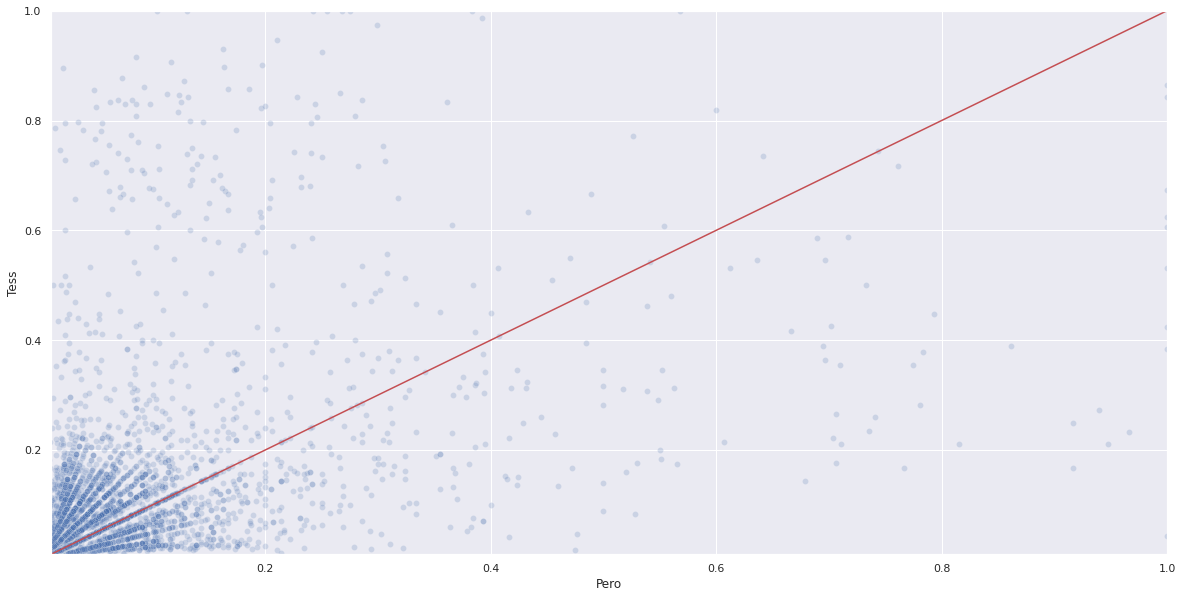

In [118]:
import seaborn as sns
import matplotlib.lines as lines
import matplotlib.pyplot as plt
sns.set_theme()

CER_pero = pero_df["Errors"] / pero_df["RefLength"]
CERnorm_pero = pero_df["Errors"] / pero_df["Length"]
CER_tess = tess_df["Errors"] / tess_df["RefLength"]
CERnorm_tess = tess_df["Errors"] / tess_df["Length"]


uniq_df = pd.DataFrame( data = [ (k[0], k[1], k[2], ref[k], boxes[k]) for k in all_keys ], columns=["Book", "Page", "Id", "TextRef", "Boxes"])
uniq_df = uniq_df.set_index(["Book", "Page", "Id"])

errors = pd.DataFrame( { "Pero": CER_pero, "Tess" : CER_tess , "PeroPred" : pero_df["TextPred"], "TessPred" : tess_df["TextPred"]})
errors = pd.concat([errors, uniq_df], axis=1, join='inner')  

fig, ax = plt.subplots(figsize=(20,10))
fig = sns.scatterplot(data = errors, x = "Pero", y = "Tess", ax=ax, alpha=0.2)
fig.add_artist(lines.Line2D([0, 1], [0, 1], color='r'))
#fig.set_xscale("log")
#fig.set_yscale("log")
fig.set_xlim(0.01, 1)
fig.set_ylim(0.01, 1)

#errors

<AxesSubplot:>

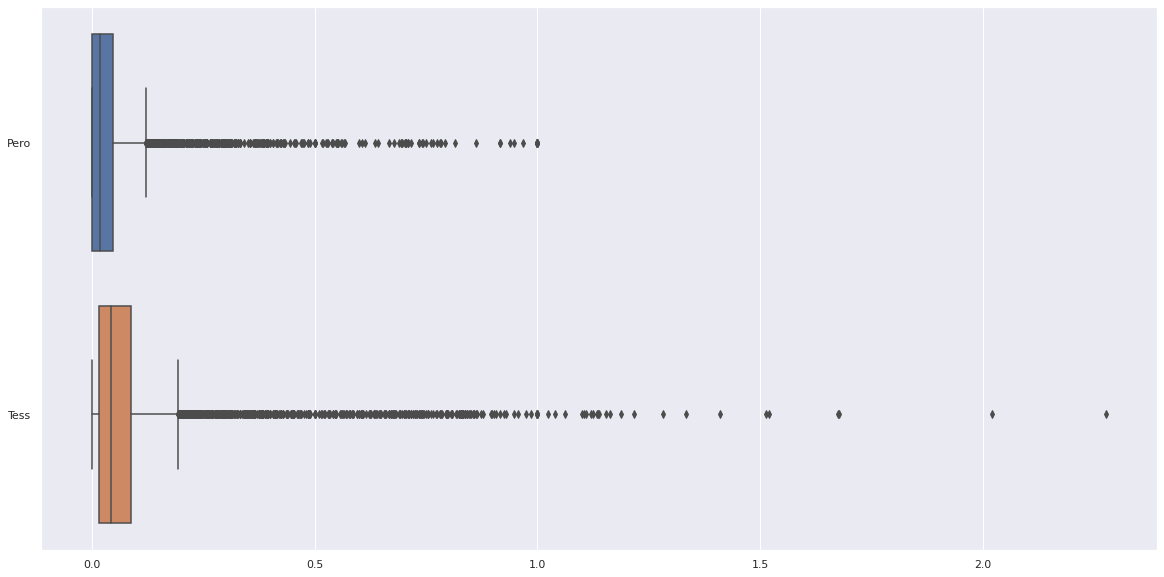

In [119]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=errors, orient='h', ax=ax)

In [120]:
byerr = errors.sort_values(by=["Pero"])
byerr[(byerr["Pero"] >= 0.9) | (byerr["Tess"] >= 0.9)]
is_valid = lambda b: b[2] > 50
valid = errors["Boxes"].apply(is_valid)
pd.options.display.float_format = '{:,.2f}'.format
errors[~valid]

Pero  Tess PeroPred  \
Book         Page Id                         
Bottin1_1820 107  306  1.00  0.61            
             201  293  1.00  1.14            
                  440  1.00  0.67            
             107  459  1.00  0.86            
                  331  1.00  0.84            
             201  289  1.00  0.62            
             107  469  1.00  0.53            

                                                                TessPred  \
Book         Page Id                                                       
Bottin1_1820 107  306        Dufen . chareutier, x. Montmartre ; 89. 818   
             201  293  Migaan , épicier, r. de la Chansséo-d'Antin,\n...   
                  440              Miguet , énicier, r: Molar,6. © : 356   
             107  459  Daflos , horloger, r. du Faub.-S.-Maitin ,\nEn...   
                  331  Doflôt ; loueur de carrosses 5% de Paradise\n ...   
             201  289          Migeon, charpentier, x, de Vaugirard ; pa   
             107  469  Dufrénoy ; rrarch. de vins ,r. Gaérin-Bois-\ns...   

                                                                 TextRef  \
Book         Page Id                                                       
Bottin1_1820 107  306             Dufay, papetier, r. S.-Martin, 20. 437   
             201  293               Miege, ag. d'affaires, r. Cléry, 84.   
                  440    Migout, limonadier, avenue de Neuilly, 15.\n396   
             107  459  Dufay, march. de toiles, r. des Mauvaises-\nPa...   
                  331  Duflocq, march. de bois a brûler, r. de\nl'Arc...   
             201  289           Midant, cordonnier, r. au Maire, 36. 296   
             107  469  Dufour, march. de vins, r. Ste.-Marguerite-\nS...   

                                    Boxes  
Book         Page Id                       
Bottin1_1820 107  306  (517, 560, -2, 17)  
             201  293   (505, 472, 0, 25)  
                  440  (510, 1260, 0, 74)  
             107  459   (517, 573, 0, 85)  
                  331   (512, 934, 5, 84)  
             201  289   (509, 417, 0, 21)  
             107  469   (931, 770, 1, 90)

In [121]:
errors.loc["Bottin1_1827",117,:].sort_index().loc[520:]

,Pero,Tess,PeroPred,TessPred,TextRef,Boxes
Id,,,,,,
525,0.02,0.80,"Devangrigneuse (Mad.), pensionnat, Perle, 3.","Devaulx, Aortoger,; S.-Honoré; 299-","Devaugrigneuse (Mad.), pensionnat, Perle, 3.","(998, 2228, 721, 38)"
527,0.00,0.71,"Devaulx, horloger, S.-Honoré, 255.","Dévaureix, asoué, Chabaunais, 3,","Devaulx, horloger, S.-Honoré, 255.","(998, 2266, 590, 34)"
529,0.03,0.66,"Devaureix, avoué, Chabannais, 3.","Devauversin.' Caire,' 33.","Devaureix, avoué, Chabaunais, 3.","(998, 2300, 528, 34)"
534,0.00,0.96,"Devauversin, Caire, 33.","Devaux /Mad.), F£.-Montimartre, 1 3.","Devauversin, Caire, 33.","(1000, 2404, 391, 36)"
536,0.00,0.65,"Devaux (Mad.), Fg.-Montmartre, 13.","Dévaüx (B') O. %, Fe.-S Honoré, 35,","Devaux (Mad.), Fg.-Montmartre, 13.","(1000, 2442, 578, 36)"
538,0.17,0.67,"Devaux\n(B3) O. *4, Fg. S.-Honoró, 35.","Devaux, S.-Nicaise, 8,","Devaux (Bn) O. , Fg.-S.-Honoré, 35.","(1000, 2478, 610, 38)"
540,0.05,1.14,"Devaux, S.-Nicaise, 8","Devaux, r'édact, à La justice, Bouloi, 8.","Devaux, S.-Nicaise, 8.","(998, 2514, 374, 34)"
542,0.00,0.72,"Devaux, rédact. à la justice, Bouloi, 8.","Dévaux, propr., Vieilles-Tuilcrics, $r.","Devaux, rédact. à la justice, Bouloi, 8.","(998, 2546, 610, 40)"
544,0.00,0.62,"Devaux, propr., Vieilles-Tuileries, 31.","Devaux, deépute, S.-Honoré, 368.","Devaux, propr., Vieilles-Tuileries, 31.","(1002, 2584, 627, 38)"


In [12]:
pero_cer = pero_df["Errors"].sum() / pero_df["RefLength"].sum()
tess_cer = tess_df["Errors"].sum() / tess_df["RefLength"].sum()

print("Pero CER: {:.2f}%".format(100 * pero_cer))
print("Tess CER: {:.2f}%".format(100 * tess_cer))
print("Pero Accuracy: {:.2f}%".format(100 * (1 - pero_cer)))
print("Tess Accuracy: {:.2f}%".format(100 * (1 - tess_cer)))

Pero CER: 3.86%
Tess CER: 7.54%
Pero Accuracy: 96.14%
Tess Accuracy: 92.46%


## With ISRI

In [7]:
import isri_tools

pero_report = isri_tools.compute_accurary_summary(list(ref.values()), list(pero.values()))
pero_report

UNLV-ISRI OCR Accuracy Report Version 5.1
-----------------------------------------
  425102   Characters
   16401   Errors
   96.14%  Accuracy

       0   Reject Characters
       0   Suspect Markers
       0   False Marks
    0.00%  Characters Marked
   96.14%  Accuracy After Correction

     Ins    Subst      Del   Errors
       0        0        0        0   Marked
    6563     7615     2223    16401   Unmarked
    6563     7615     2223    16401   Total

   Count   Missed   %Right
   54436     3234    94.06   ASCII Spacing Characters
   57963     3885    93.30   ASCII Special Symbols
   18175     1501    91.74   ASCII Digits
   31990      601    98.12   ASCII Uppercase Letters
  255390     3525    98.62   ASCII Lowercase Letters
      66       41    37.88   Latin1 Special Symbols
      51       44    13.73   Latin1 Uppercase Letters
    6235      914    85.34   Latin1 Lowercase Letters
      25        7    72.00   Latin Extended-A
     383       42    89.03   General Punctuation
 

In [9]:
tess_report = isri_tools.compute_accurary_summary(list(ref.values()), list(tess.values()))
tess_report

UNLV-ISRI OCR Accuracy Report Version 5.1
-----------------------------------------
  425102   Characters
   32061   Errors
   92.46%  Accuracy

       0   Reject Characters
       0   Suspect Markers
       0   False Marks
    0.00%  Characters Marked
   92.46%  Accuracy After Correction

     Ins    Subst      Del   Errors
       0        0        0        0   Marked
    5501    18702     7858    32061   Unmarked
    5501    18702     7858    32061   Total

   Count   Missed   %Right
   54436     1912    96.49   ASCII Spacing Characters
   57963     5078    91.24   ASCII Special Symbols
   18175     2742    84.91   ASCII Digits
   31990     2651    91.71   ASCII Uppercase Letters
  255390    10402    95.93   ASCII Lowercase Letters
      66       26    60.61   Latin1 Special Symbols
      51       26    49.02   Latin1 Uppercase Letters
    6235      934    85.02   Latin1 Lowercase Letters
      25       10    60.00   Latin Extended-A
     383       34    91.12   General Punctuation
 